In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

In [3]:
alpha = 0.5
color_mode = 'continuous'

In [4]:
save_figs = True
plot_dir = '../plots/2023-01-08_figures'
Path(plot_dir).mkdir(parents=True, exist_ok=True)
plot_tag = ''

## Load SAM data & params

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [8]:
fn_idxs = '../data/idxs_camelssam_in_emu_bounds.dat'
#idxs_sam = np.loadtxt(fn_idxs, dtype=int)

idxs_sam = [idx_sam for idx_sam in np.arange(0, 1000) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]

In [9]:
n_sams = len(idxs_sam)
print(n_sams)

1000


In [11]:
fn_params = '../data/params_CAMELS-SAM.dat'
df_params = pd.read_csv(fn_params, index_col='idx_LH')

# Plot SMFs

In [15]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)    

0.302246803431
3308554.428527777 1000000


In [16]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2. 

In [17]:
smf_arr = []
ndens_arr = []
for idx_sam in idxs_sam:
    fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        ndens = len(log_mstar[log_mstar>edges[0]])/vol_Mpc
        #ndens = len(log_mstar)/vol_Mpc
        ndens_arr.append(ndens)

/tmp/ipykernel_404388/3454199343.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [28]:
def get_colors(colorby_arr, cmap='viridis'):
    locs_norm = matplotlib.colors.Normalize(np.min(colorby_arr), np.max(colorby_arr), len(colorby_arr))
    cmap = matplotlib.colormaps[cmap]
    colors = cmap(locs_norm(colorby_arr))
    return colors, cmap, locs_norm

In [29]:
param_names = df_params.columns
print(param_names)

Index(['Omega_m', 'sigma_8', 'A_SN1_x1.7', 'A_SN2_p3', 'A_AGN_x0.002'], dtype='object')


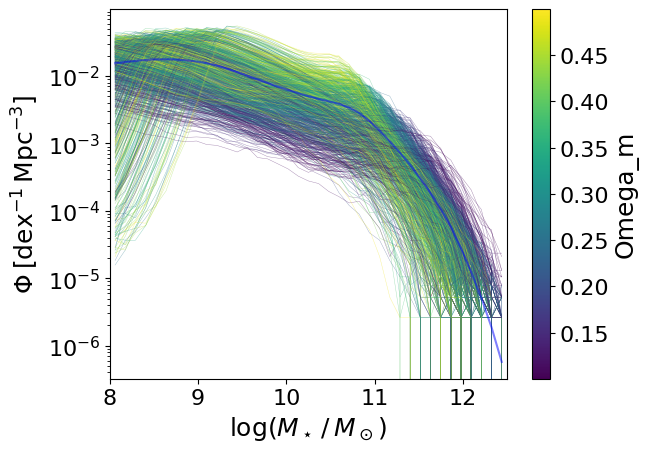

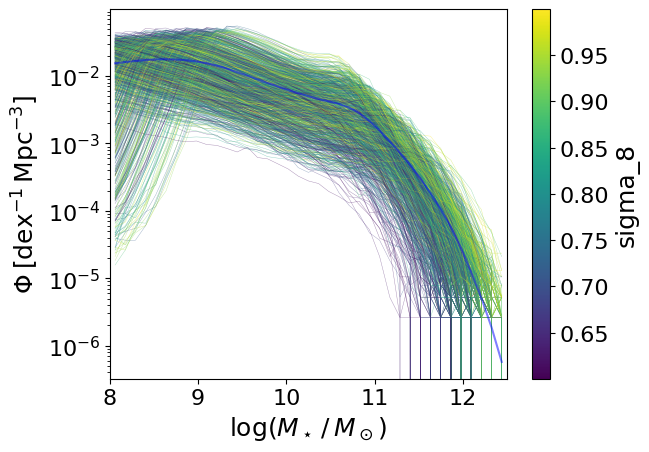

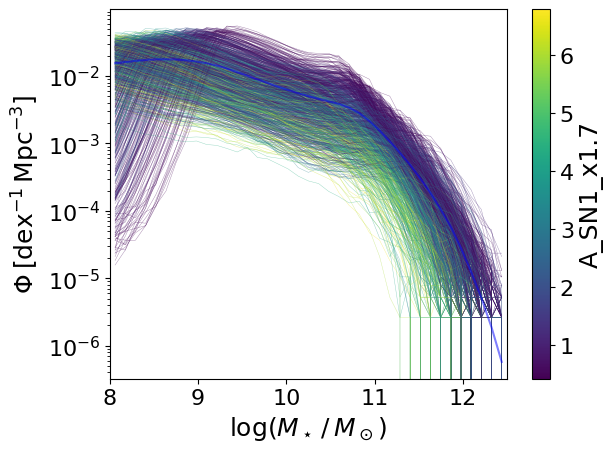

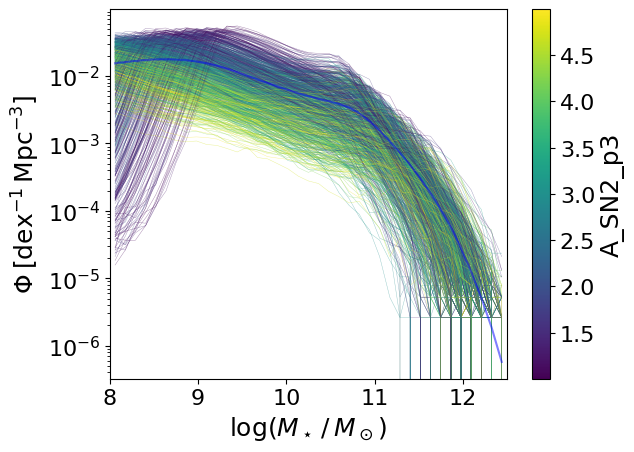

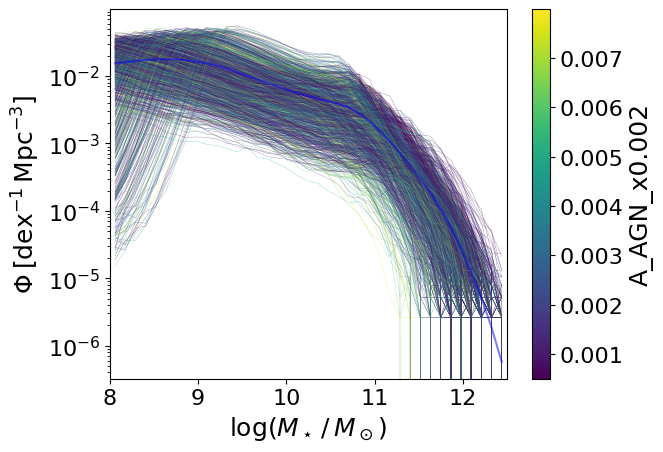

In [30]:
for param_name in param_names:
    
    colors, cmap, locs_norm = get_colors(df_params.loc[idxs_sam, param_name])

    plt.figure()
    for i in range(n_sams):
        plt.plot(bins_avg, smf_arr[i], lw=0.3, color=colors[i], alpha=alpha)
        
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
    plt.colorbar(sm, ax=ax, label=param_name)

    smf_mean = np.mean(smf_arr, axis=0)
    smf_std = np.std(smf_arr, axis=0)
    plt.plot(bins_avg, smf_mean, color='blue', alpha=alpha)

    plt.yscale('log')
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
    plt.xlim(8, 12.5)

## check out number density / min stellar mass relation

In [55]:
ndens_targets = [0.0003, 0.001, 0.003, 0.01] # h^3 Mpc^-3

In [61]:
min_mstar_ndens_arr = []
for ndens_target in ndens_targets:
    n_target = int(ndens_target * vol_hMpc)
    print(n_target)

    min_mstar_arr = []
    for idx_sam in idxs_sam:
        fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
        with h5py.File(fn_dat, 'r') as f:
            mstar_raw = np.array(f['mstar'])
            log_mstar = np.log10(mstar_raw) + log_mass_shift
            # checked that all these ways to get min_mstar work fine
            #i_target = np.argsort(log_mstar)[::-1][:n_target]
            #i_target = np.argsort(log_mstar)[-n_target:]
            #min_mstar = np.min(log_mstar[i_target])
            
            min_mstar = np.sort(log_mstar)[::-1][n_target]
            min_mstar_arr.append(min_mstar)
            
    min_mstar_ndens_arr.append(min_mstar_arr)

300


/tmp/ipykernel_404388/4150059708.py:11: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


1000
3000
10000


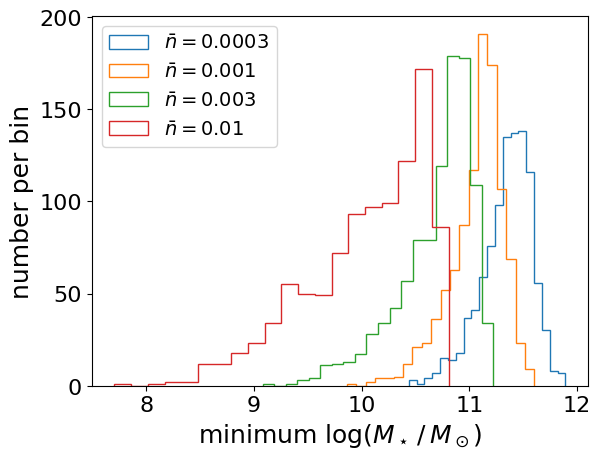

In [62]:
for i, ndens_target in enumerate(ndens_targets):
    plt.hist(min_mstar_ndens_arr[i], histtype='step', bins=20, label=rf'$\bar{{n}} = {ndens_targets[i]}$')
    
plt.xlabel(r'minimum $\log(M_\star\,/\,M_\odot)$')
plt.ylabel('number per bin')
plt.legend()